In [10]:
from sktime.annotation.hmm_learn import PoissonHMM 
from sktime.annotation.datagen import piecewise_poisson 
data = piecewise_poisson( 
   lambdas=[1, 2, 3], lengths=[2, 4, 8], random_state=7
   ).reshape((-1, 1))
print(data)
model = PoissonHMM(n_components=3) 
model = model.fit(data) 
labeled_data = model.predict(data) 
print(labeled_data)

[[0]
 [1]
 [4]
 [1]
 [3]
 [2]
 [2]
 [5]
 [4]
 [3]
 [4]
 [3]
 [4]
 [4]]
[1 0 2 0 2 0 2 0 2 0 2 0 2 0]


C:\Users\xieyi\AppData\Local\Temp\ipykernel_26212\3744246860.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['bgl'] = df['bgl'].fillna(method='ffill')


[0 1]


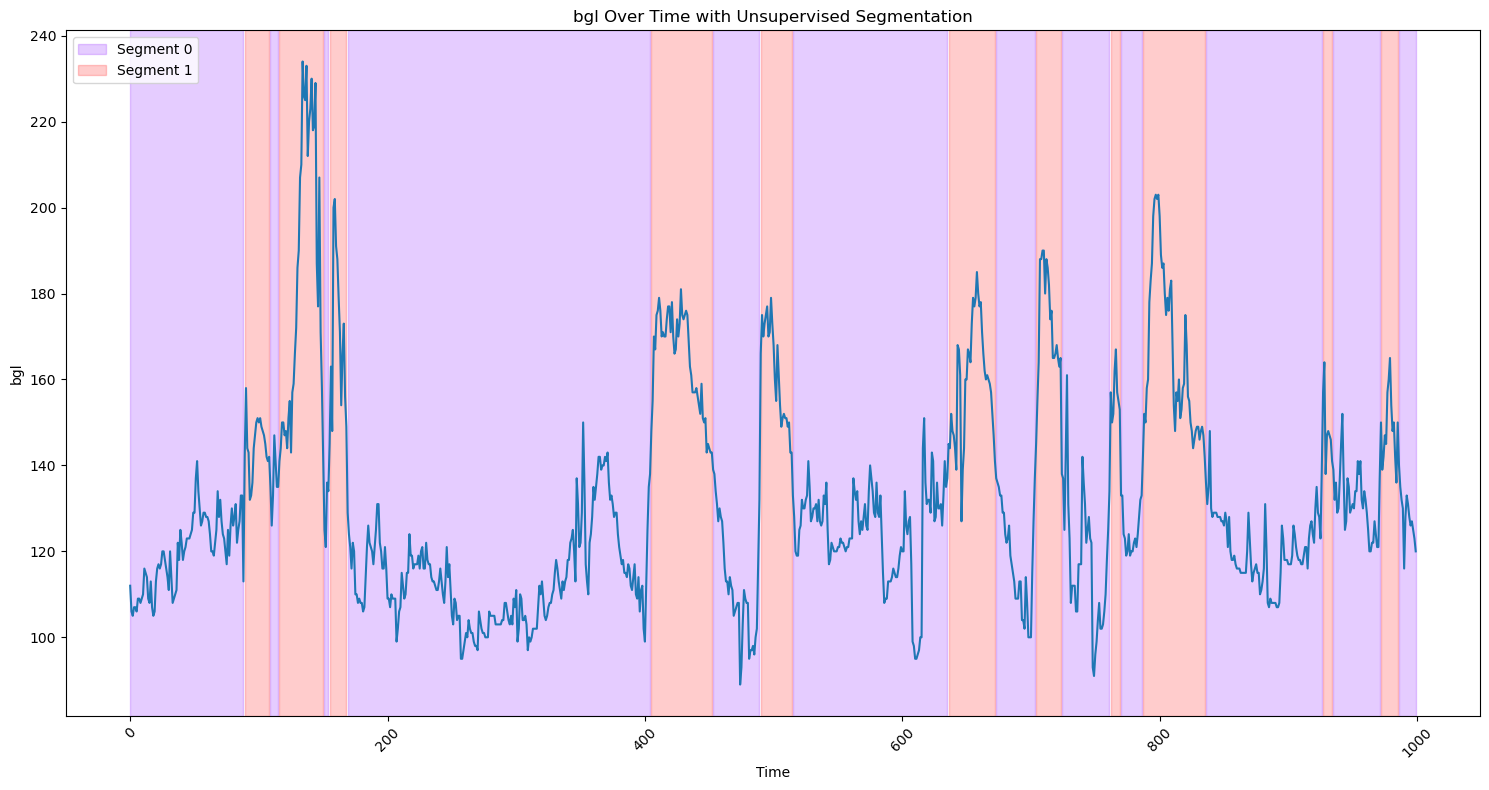

[0 1 2 3 4 5 6 7 8]


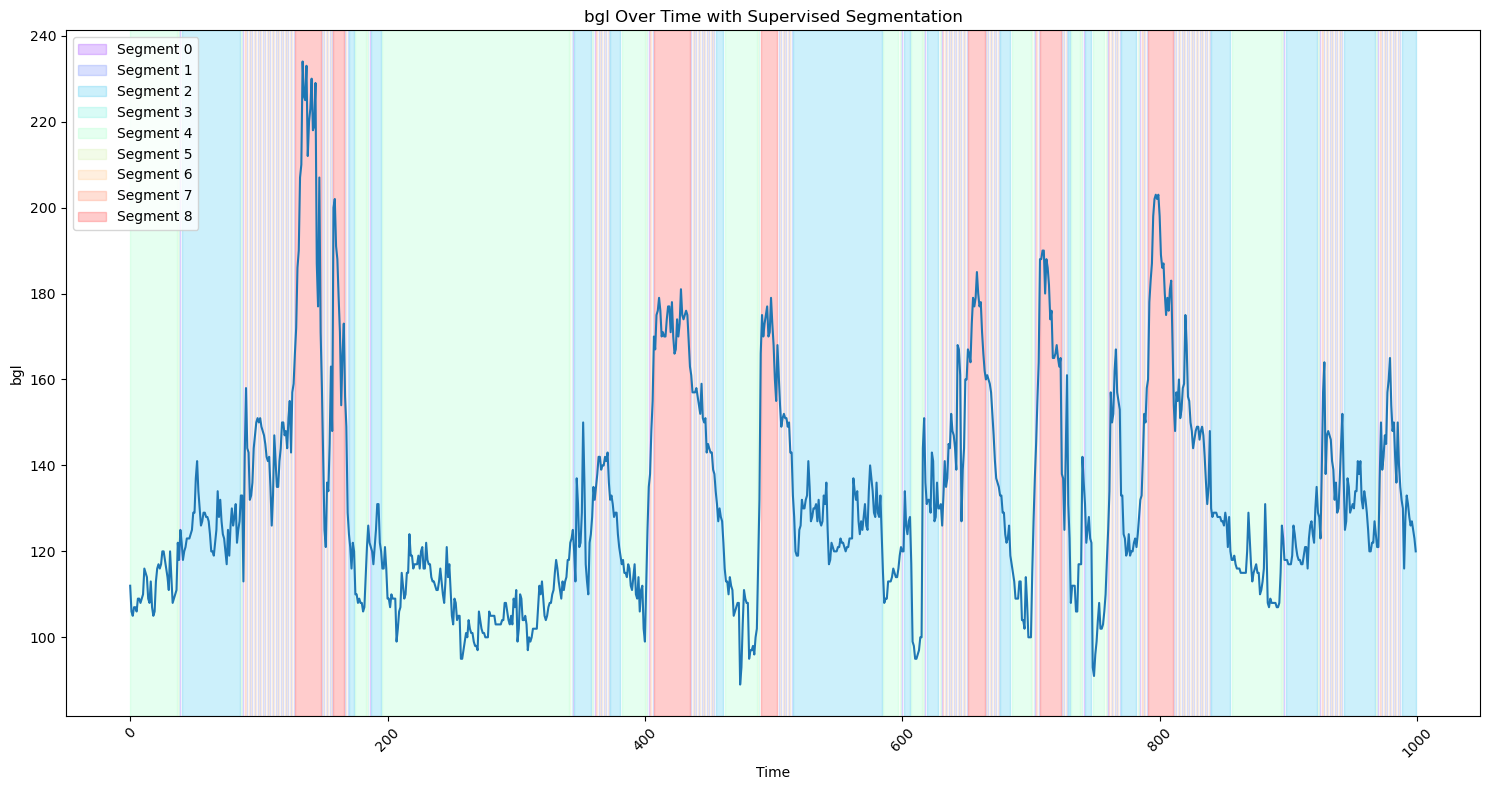

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


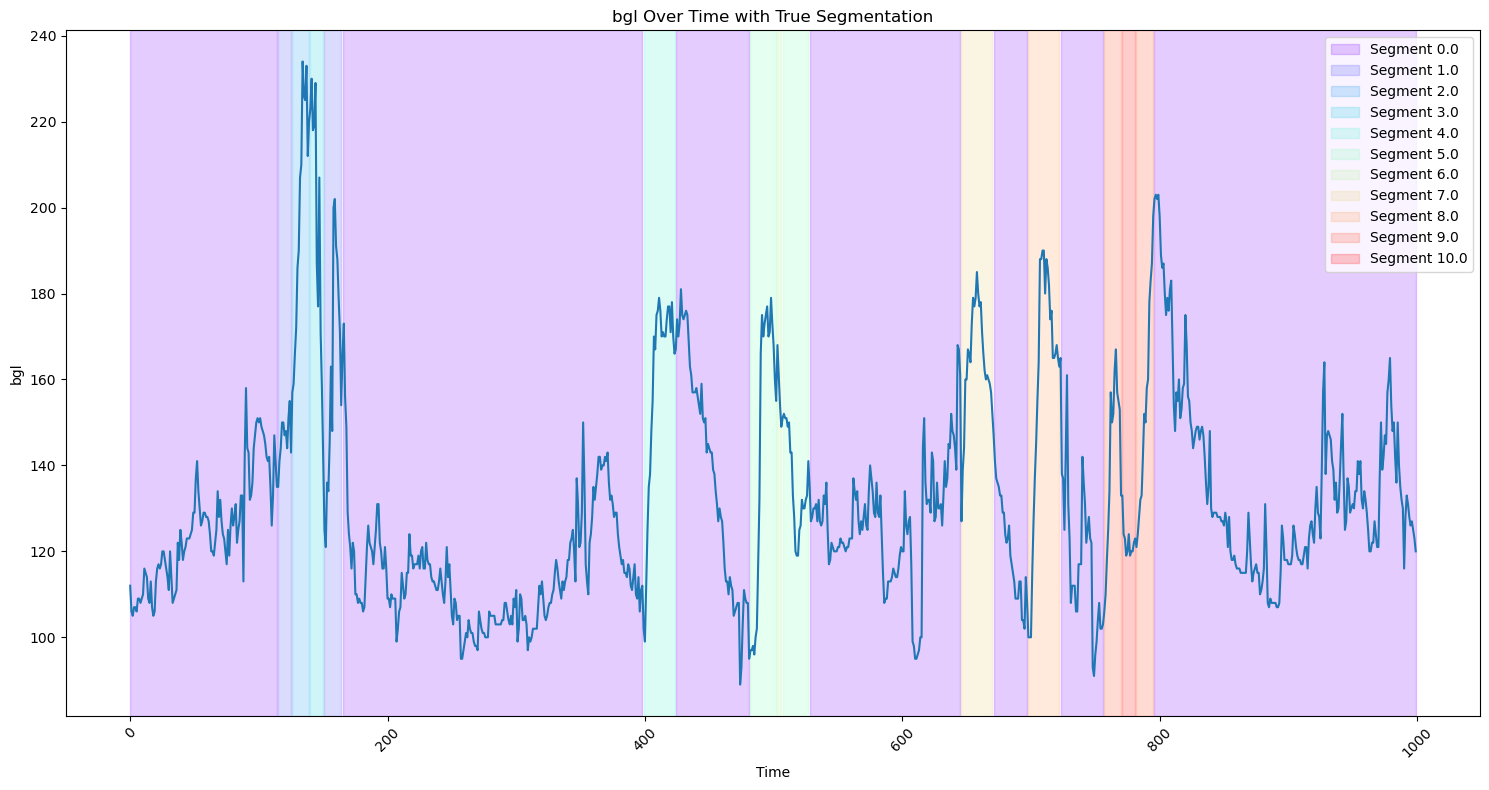

In [8]:
import pandas as pd
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datatypes import convert_to
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.annotation.hmm_learn import PoissonHMM 
from sktime.annotation.datagen import piecewise_poisson
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import os

def load_data(data_path='../data/interim/meal_annotation_plus_2hr_meal.csv'):
    df = pd.read_csv(data_path, parse_dates = ['day_4am'])
    df['bgl'] = df['bgl'].fillna(method='ffill')
    df['dose_units'] = df['dose_units'].fillna(0)
    df['food_g'] = df['food_g'].fillna(0)
    df['msg_type'] = df['msg_type'].replace(0, 'NULL')
    df['day_4am'] = pd.to_datetime(df['day_4am'], utc=True) - pd.to_datetime('2024-07-01', utc=True)
    df['day_4am'] = pd.to_timedelta(df['day_4am'], 'D').dt.days
    return df

def create_meal_labels(df):
    labels = np.zeros(len(df))
    meal_start = df['msg_type'] == 'ANNOUNCE_MEAL'
    meal_end = df['msg_type'] == 'MEAL_END'
    
    meal_counter = 1
    active_meals = []
    max_meals = 0
    
    for i in range(len(df)):
        if meal_start.iloc[i]:
            active_meals.append(meal_counter)
            max_meals = meal_counter
            meal_counter += 1
        
        if len(active_meals) > 0:
            labels[i] = active_meals[-1]
        
        if meal_end.iloc[i] and len(active_meals) > 0:
            active_meals.pop()
    
    return labels, max_meals

def OneHotPreprocess(df):
    # one hot encode msgtype:
    one_hot_msg = pd.get_dummies(df['msg_type'])
    one_hot_msg = one_hot_msg.add_prefix('msg_type_')
    one_hot_msg = one_hot_msg.astype(int)
    RELEVANT_MSG_TYPES = ['ANNOUNCE_MEAL', 'MEAL_END', 'INTERVENTION_SNACK', 'ANNOUNCE_EXERCISE', 'DOSE_INSULIN', 'DOSE_BASAL_INSULIN']
    one_hot_msg = one_hot_msg.drop(columns=[col for col in one_hot_msg.columns if  not any(msg_type in col for msg_type in RELEVANT_MSG_TYPES)])
    df = df.drop('msg_type', axis=1)
    df = df.join(one_hot_msg)
    return df

def PoissonHMMSegmentation(df, labels=None):
    # X = df.drop(columns=[c for c in df.columns if c.lower()[:8] == 'msg_type'])
    X = df['bgl']
    Y = None
    if(labels is None):
        model = PoissonHMM(n_components=2)
    else:
        model = PoissonHMM(n_components=label[1])
        Y = pd.Series(labels[0])
    X = X.copy()
    model = model.fit(X, Y)
    labeled_data = model.predict(X)
    # print(labeled_data)
    # print(labels)
    return X, labeled_data

def visualize_segmentation(X_nested, segmentation, title=None):
    plt.figure(figsize=(15, 8))
    
    # plot the time series
    plt.plot(X_nested.index, X_nested.values.flatten())
    
    # plot segmentation
    unique_segments = np.unique(segmentation)
    print(unique_segments)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_segments)))
    
    for segment, color in zip(unique_segments, colors):
        mask = segmentation == segment
        # print(X_nested.index[mask])
        min_idx = 0
        idx = 0
        while(idx < len(X_nested.index[mask])-1):
            if(X_nested.index[mask][idx+1] != X_nested.index[mask][idx]+1):
                plt.axvspan(X_nested.index[mask][min_idx], X_nested.index[mask][idx], 
                    alpha=0.2, color=color, label=f'Segment {segment}')
                min_idx = idx+1
            idx+=1
        plt.axvspan(X_nested.index[mask][min_idx], X_nested.index[mask][idx],
                    alpha=0.2, color=color, label=f'Segment {segment}')
        # for m in X_nested.index[mask]:
        #     plt.axvspan(m, m+1, 
        #             alpha=0.2, color=color, label=f'Segment {segment}')
        # plt.axvspan(X_nested.index[mask].min(), X_nested.index[mask].max(), 
        #             alpha=0.2, color=color, label=f'Segment {segment}')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(f'bgl Over Time with {title} Segmentation')
    plt.xlabel('Time')
    plt.ylabel('bgl')
    # plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

df = load_data().head(1000)
label = create_meal_labels(df)
df = OneHotPreprocess(df)
X, us_prediction = PoissonHMMSegmentation(df, None)
X, s_prediction = PoissonHMMSegmentation(df, label)
visualize_segmentation(X, us_prediction.to_list(), 'Unsupervised')
visualize_segmentation(X, s_prediction.to_list(), 'Supervised')
visualize_segmentation(X, label[0], 'True')

